# From Shakespearian to modern English

Elise Barrère (ENSAE) | Vincent Delale (ENSAE)

## Table of Contents
* [Explore the books](#exploration)
    * [Exploration based on the number of characters](#numchar)
    * [Exploration based on the number of words](#numwords)
    * [Wordclouds](#wordclouds)
* [Translation](#translation)
    * [Cleaning](#cleaning)
    * [Tokenization](#tokenization)
    * [Vocabulary](#vocab)
    

In [ ]:
# download missing packages
! pip install datasets transformers torchinfo

In [70]:
# Imports packages
import pandas as pd
pd.set_option('display.max_colwidth', None) 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import numpy as np

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
nltk.download('punkt')

from datasets import load_dataset
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elise\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# import data
url_books = 'https://raw.githubusercontent.com/vdelale/NLP-ENSAE/main/data/books/{}.csv'
book_titles = ['hamlet', 'lear', 'macbeth', 'othello']

full_books = []
for book in book_titles:
    tmp = pd.read_csv(url_books.format(book), index_col=0)
    tmp['book'] = book
    full_books.append(tmp)

In [6]:
df = pd.concat(full_books)
df.index = range(len(df))

In [7]:
df.head()

,original,modern,book
0,Who’s there?,Who’s there?,hamlet
1,"Nay, answer me. Stand and unfold yourself.","No, who are you? Stop and identify yourself.",hamlet
2,Long live the king!,Long live the king!,hamlet
3,Barnardo?,Is that Barnardo?,hamlet
4,He.,"Yes, it’s me.",hamlet


## Explore the books
<a class="anchor" id="exploration"></a>

### Exploration based on the number of characters
<a class="anchor" id="numchar"></a>


In [10]:
df['original_length'] = df.original.apply(lambda x : len(x.replace(' ', '')))
df['modern_length'] = df.modern.apply(lambda x : len(x.replace(' ', '')))

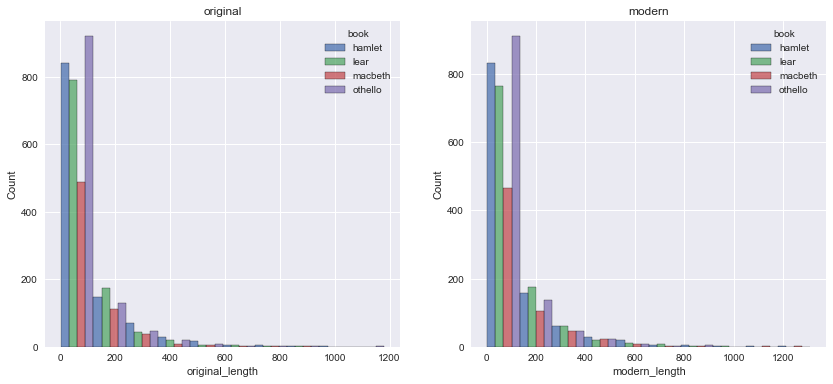

In [11]:
# Repartition of the content lengths (characters)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
sns.histplot(data=df, x='original_length', ax=axs[0], hue='book', bins=10, multiple="dodge")
sns.histplot(data=df, x='modern_length', hue='book', ax=axs[1], bins=10,  multiple="dodge")

axs[0].set_title('original')
# sns.histplot(data=df, x='modern_length', hue='book')
axs[1].set_title('modern')

plt.show()

We can see that the repartition of line length is quite similar among the plays, except for othello which tend to be shorter.

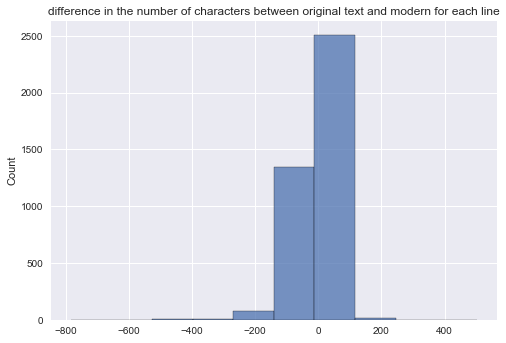

In [12]:
sns.histplot(df['original_length'] - df['modern_length'], bins=10)
plt.title('difference in the number of characters between original text and modern for each line')
plt.show()

We can see that overall there is not much difference in term of length between the orginal version of the text and its translation. But, the modern text tends to be a little bit longer. It can be due to the fact that the translation is made to help student understand the meaning of the text rather than being stylisticly pretty etc. Could also be because modern English requires more words/characters. 

### Exploration based on the number of words
<a class="anchor" id="numwords"></a>

In [13]:
df['original_words'] = df.original.apply(lambda x : len(x.split(' ')))
df['modern_words'] = df.modern.apply(lambda x : len(x.split(' ')))

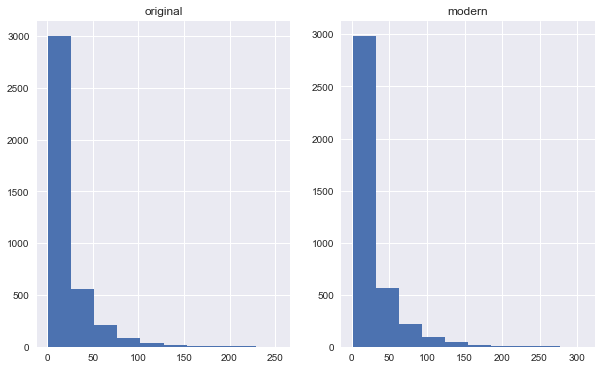

In [14]:
# Repartition of the content lengths (words)

fig, axs = plt.subplots(1, 2, figsize=(10,6))
axs[0].hist(df['original_words'])
axs[0].set_title('original')
axs[1].hist(df['modern_words'])
axs[1].set_title('modern')

plt.show()


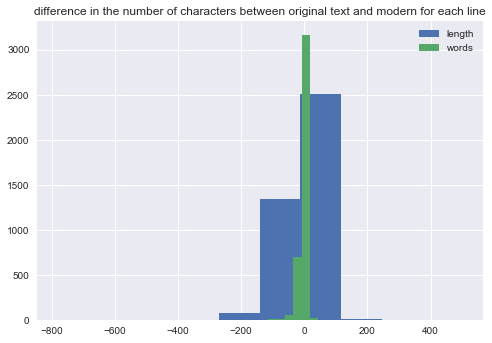

In [15]:
plt.hist(df['original_length'] - df['modern_length'], label='length')
plt.hist(df['original_words'] - df['modern_words'], label='words')
plt.legend()
plt.title('difference in the number of characters between original text and modern for each line')
plt.show()

Similarly, there is often an analogous number of words between the original and the modern text

### Wordclouds
<a class="anchor" id="wordclouds"></a>

In [33]:
modern_stopwords = set(stopwords.words('english'))
original_stopwords = pd.read_csv('https://raw.githubusercontent.com/vdelale/NLP-ENSAE/main/old_en_stopwords.txt',
                         header=None, names=['original'])['original'].values

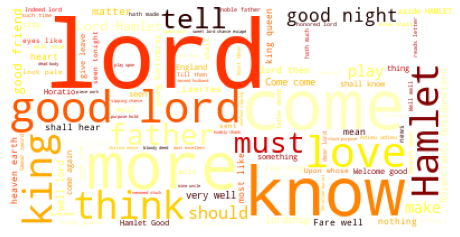

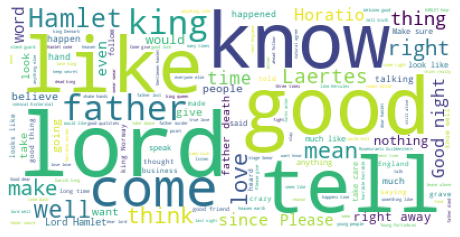

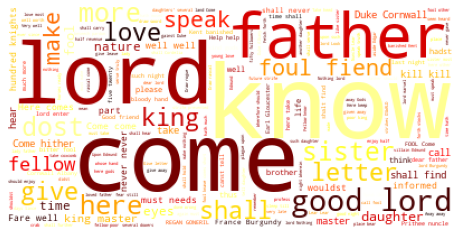

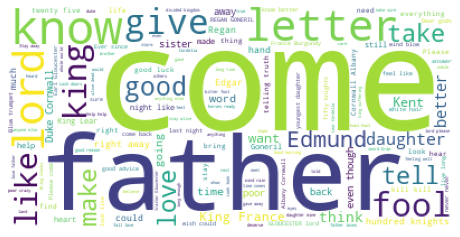

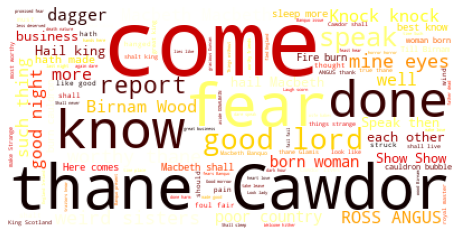

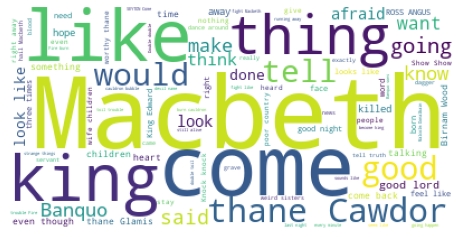

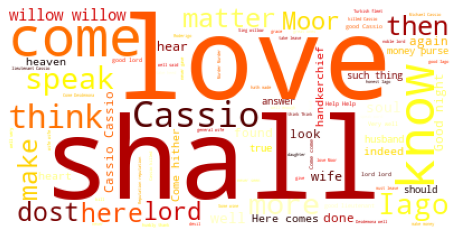

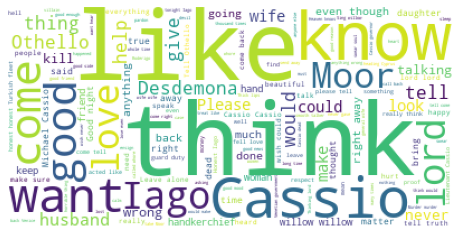

In [35]:
modern_text = " ".join(df['modern'].values)
original_text = " ".join(df['original'].values)
for b in df.book.unique():
    original_text_book = " ".join(df[df['book'] == b]['original'].values)
    wordcloud = WordCloud(background_color = 'white', stopwords = original_stopwords,
                          colormap=plt.cm.hot,
                          collocation_threshold=5, min_word_length=4).generate(original_text_book)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

    modern_text_book = " ".join(df[df['book'] == b]['modern'].values)
    wordcloud = WordCloud(background_color = 'white', stopwords = modern_stopwords,
                          collocation_threshold=5, min_word_length=4).generate(modern_text_book)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

## Translation
<a class="anchor" id="translation"></a>
### Cleaning
<a class="anchor" id="cleaning"></a>

In [36]:
import re
def remove_indications(text):
    new_text = re.sub("[\(].*?[\)]", "", text)
    return new_text
df['modern_clean'] = df['modern'].apply(remove_indications)


### Tokenization
<a class="anchor" id="tokenization"></a>

In [40]:
tok = TreebankWordTokenizer()

In [41]:
df['modern_tok'] = df['modern'].apply(lambda x: tok.tokenize(x.lower().strip()))
df['original_tok'] = df['original'].apply(lambda x: tok.tokenize(x.lower().strip()))

### Vocabulary
<a class="anchor" id="vocab"></a>

In [42]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [43]:
VOC = {'original_en': {'stoi': {}, 'counts': {}, 'nbwords': 0}, 'modern_en': {'stoi': {}, 'counts': {}, 'nbwords': 0}}

In [44]:
LANGS = ['original_en', 'modern_en']
for lang in LANGS:
  for t in special_symbols: 
    VOC[lang]['stoi'][t] = VOC[lang]['nbwords']
    VOC[lang]['counts'][t] = 1
    VOC[lang]['nbwords'] += 1

In [45]:
tokens_modern = df.modern_tok.values
for tokens in tokens_modern:
    for t in tokens:
        if t not in VOC['modern_en']['stoi']: 
            VOC['modern_en']['stoi'][t] = VOC['modern_en']['nbwords']
            VOC['modern_en']['counts'][t] = 1
            VOC['modern_en']['nbwords'] += 1
        else:
            VOC['modern_en']['counts'][t] = VOC['modern_en']['counts'][t] + 1

In [46]:
tokens_original = df.original_tok.values
for tokens in tokens_original:
    for t in tokens:
        if t not in VOC['original_en']['stoi']: 
            VOC['original_en']['stoi'][t] = VOC['original_en']['nbwords']
            VOC['original_en']['counts'][t] = 1
            VOC['original_en']['nbwords'] += 1
        else:
            VOC['original_en']['counts'][t] = VOC['original_en']['counts'][t] + 1

In [47]:
for lang in LANGS:
  VOC[lang]['itos'] = { v:k for k,v in VOC[lang]['stoi'].items()}

In [48]:
print('modern_en', VOC['modern_en']['nbwords'], 'original_en', VOC['original_en']['nbwords'])

modern_en 9133 original_en 10249


In [49]:
def prepa(entry, lang):
    tokens_entry =   [SOS_IDX] + [ VOC[lang]['stoi'][t] for t in entry ] + [EOS_IDX]   
    return tokens_entry

In [50]:
df['modern_en'] = df['modern_tok'].apply(lambda x: prepa(x, 'modern_en'))

In [51]:
df['original_en'] = df['original_tok'].apply(lambda x: prepa(x, 'original_en'))

In [52]:
from sklearn.model_selection import train_test_split

df_train, other = train_test_split(df, test_size=0.33, random_state=42)
df_test, df_val = train_test_split(other, test_size=0.5, random_state=42)


In [53]:
print(len(df_train), len(df_test), len(df_val))

2642 651 651


### Pytorch model
<a class="anchor" id="pytorch"></a>

#### Dataset
<a class="anchor" id="dataset"></a>

In [56]:
class OrModDataset(Dataset):
    def __init__(self, data):
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "modern_en": torch.from_numpy(np.array(self.data.loc[idx]['modern_en'])),
          "original_en": torch.from_numpy(np.array(self.data.loc[idx]['original_en']))
      }
      return(torch.LongTensor(item['original_en']),
             torch.LongTensor(item['modern_en']))


In [66]:
train_set = OrModDataset(df_train.reset_index())
val_set   = OrModDataset(df_val.reset_index())
test_set  = OrModDataset(df_test.reset_index())

Encoder

In [57]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, padding_idx, dropout_GRU):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, dropout=dropout_GRU, num_layers=2)
    
    def forward(self, input):
        input = self.embedding(input)
        hs, _ = self.rnn(input)
        # print(hs.size())
        return hs

#### Attention Layer

In [58]:
class seq2seqAtt(nn.Module):
    def __init__(self, hidden_dim, hidden_dim_s, hidden_dim_t):
        super(seq2seqAtt, self).__init__()
        self.ff_concat = nn.Linear(hidden_dim_s+hidden_dim_t, hidden_dim)
        self.ff_score = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, target_h, source_hs):
        target_h_rep = target_h.repeat(source_hs.size(0), 1, 1) # (1, batch, feat) -> (seq, batch, feat)
        
        concat_output = torch.cat((target_h_rep, source_hs), dim=2)
        scores = self.ff_score(torch.tanh(self.ff_concat(concat_output))) # should be of shape (seq, batch, 1)
        scores = scores.squeeze(dim=2) # (seq, batch, 1) -> (seq, batch). dim = 2 because we don't want to squeeze the batch dim if batch size = 1
        norm_scores = torch.softmax(scores, 0)
        source_hs_p = source_hs.permute((2, 0, 1)) # (seq, batch, feat) -> (feat, seq, batch)
        weighted_source_hs = (norm_scores * source_hs_p) # (seq, batch) * (feat, seq, batch) (* checks from right to left that the dimensions match)
        ct = torch.sum(weighted_source_hs.permute((1, 2, 0)), 0, keepdim=True) # (feat, seq, batch) -> (seq, batch, feat) -> (1, batch, feat); keepdim otherwise sum squeezes 
        return ct, norm_scores

#### Decoder

In [59]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, padding_idx):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim)
        self.ff_concat = nn.Linear(2*hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, input, source_context, h):

        input = self.embedding(input)
        h_t, _ = self.rnn(input, h)
        tilde_h = torch.tanh(self.ff_concat(torch.cat((h_t, source_context), dim=2)))
        prediction = self.predict(tilde_h)
        return prediction, h_t

In [73]:
class seq2seqModel(nn.Module):
    '''the full seq2seq model'''
    ARGS = ['vocab_s','vocab_t_inv','embedding_dim_s','embedding_dim_t',
     'hidden_dim_s','hidden_dim_t','hidden_dim_att','do_att','padding_token',
     'unk_token','sos_token','eos_token','max_size', 'dropout_GRU']
    def __init__(self, vocab_s, vocab_t_inv, embedding_dim_s, embedding_dim_t, 
                 hidden_dim_s, hidden_dim_t, hidden_dim_att, do_att, padding_token,
                 unk_token, sos_token, eos_token, max_size, dropout_GRU):
        super(seq2seqModel, self).__init__()
        self.vocab_s = vocab_s
        self.vocab_t_inv = vocab_t_inv
        self.embedding_dim_s = embedding_dim_s
        self.embedding_dim_t = embedding_dim_t
        self.hidden_dim_s = hidden_dim_s
        self.hidden_dim_t = hidden_dim_t
        self.hidden_dim_att = hidden_dim_att
        self.do_att = do_att 
        self.padding_token = padding_token
        self.unk_token = unk_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.max_size = max_size
        self.dropout_gru = dropout_GRU
        
        self.max_source_idx = max(list(vocab_s.values()))
        print('max source index',self.max_source_idx)
        print('source vocab size',len(vocab_s))
        
        self.max_target_idx = max([int(elt) for elt in list(vocab_t_inv.keys())])
        print('max target index',self.max_target_idx)
        print('target vocab size',len(vocab_t_inv))
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encoder = Encoder(self.max_source_idx+1, self.embedding_dim_s, self.hidden_dim_s, self.padding_token, 
                               self.dropout_gru).to(self.device)
        self.decoder = Decoder(self.max_target_idx+1, self.embedding_dim_t, self.hidden_dim_t, self.padding_token).to(self.device)
        
        if self.do_att:
            print(self.hidden_dim_att,  self.hidden_dim_s , self.hidden_dim_t)
            self.att_mech = seq2seqAtt(self.hidden_dim_att, self.hidden_dim_s, self.hidden_dim_t).to(self.device)
    
    def my_pad(self, my_list):
        batch_source = pad_sequence([torch.cat((elt[0], torch.LongTensor([self.eos_token]))) for elt in my_list], batch_first=True, padding_value=self.padding_token)
        batch_target = pad_sequence([torch.cat((elt[1], torch.LongTensor([self.eos_token]))) for elt in my_list], batch_first=True, padding_value=self.padding_token)
        return batch_source, batch_target
    
    def forward(self, input, max_size, is_prod):
        if is_prod: 
            input = input.unsqueeze(1) 
        current_batch_size = input.size(1)

        # use the encoder
        source_hs = self.encoder(input)
        # = = = decoder part (one timestep at a time)  = = =
        target_h = torch.zeros(size=(1, current_batch_size, self.hidden_dim_t)).to(self.device) # init (1, batch, feat)
        


        target_input = torch.LongTensor([self.sos_token]).repeat(current_batch_size).unsqueeze(0).to(self.device) # init (1, batch)
        pos = 0
        eos_counter = 0
        logits = []
        
        alpha_mat = []
        while True:
            if self.do_att:
                source_context, norm_scores = self.att_mech(target_h, source_hs)
                alpha_mat.append(norm_scores)
            else:
                source_context = source_hs[-1, :, :].unsqueeze(0) # (1, batch, feat) last hidden state of encoder

            prediction, target_h = self.decoder(target_input, source_context, target_h)
            logits.append(prediction) # (1, batch, vocab)

            target_input = prediction.argmax(-1)
            eos_counter += torch.sum(target_input==self.eos_token).item()
            pos += 1
            if pos >= max_size or (eos_counter == current_batch_size and is_prod):
                break
        to_return = torch.cat(logits, 0) #  (seq, batch, vocab)
        
        if is_prod:
            to_return = to_return.squeeze(dim=1) # (seq, vocab)
        
        return to_return, alpha_mat
    
    def fit(self, trainingDataset, testDataset, lr, batch_size, n_epochs, patience, criterion):
        parameters = [p for p in self.parameters() if p.requires_grad]
        optimizer = optim.Adam(parameters, lr=lr)
        loss = criterion(ignore_index=self.padding_token) # the softmax is inside the loss!

        train_loader = DataLoader(trainingDataset, batch_size=batch_size, 
                                       shuffle=True, collate_fn=self.my_pad) 
        test_loader = DataLoader(testDataset, batch_size=512,
                                      collate_fn=self.my_pad)
        tdqm_dict_keys = ['loss', 'test loss']
        tdqm_dict = dict(zip(tdqm_dict_keys, [0.0, 0.0]))
        patience_counter = 1
        patience_loss = 99999
        
        for epoch in range(n_epochs): 
            with tqdm(total=len(train_loader), unit_scale=True, postfix={'loss':0.0, 'test loss':0.0},
                      desc="Epoch : %i/%i" % (epoch, n_epochs-1), ncols=100) as pbar:
                for loader_idx, loader in enumerate([train_loader, test_loader]):
                    total_loss = 0
                    # print('start enumerater')
                    if loader_idx == 0:
                        self.train()
                    else:
                        self.eval()
                    # print('start')
                    for i, (batch_source, batch_target) in enumerate(loader):
                        batch_source = batch_source.transpose(1, 0).to(self.device) # RNN needs (seq, batch, feat) but loader returns (batch, seq)                        
                        batch_target = batch_target.transpose(1, 0).to(self.device) # (seq, batch)
                        
                        # are we using the model in production
                        is_prod = len(batch_source.shape) == 1 
                        if is_prod:
                            max_size = self.max_size
                            self.eval()
                        else:
                            max_size = batch_target.size(0) # no need to continue generating after we've exceeded the length of the longest ground truth sequence
                        
                        unnormalized_logits, _ = self.forward(batch_source, max_size, is_prod)
                        sentence_loss = loss(unnormalized_logits.flatten(end_dim=1), batch_target.flatten())
                        total_loss += sentence_loss.item()                  
                        tdqm_dict[tdqm_dict_keys[loader_idx]] = total_loss/(i+1)                       
                        pbar.set_postfix(tdqm_dict)                     
                        if loader_idx == 0:
                            optimizer.zero_grad() # flush gradient attributes
                            sentence_loss.backward() # compute gradients
                            optimizer.step() # update
                            pbar.update(1)
            
            if total_loss > patience_loss:
                patience_counter += 1
            else:
                patience_loss = total_loss
                patience_counter = 1 # reset
            
            if patience_counter > patience:
                break
    
    def sourceNl_to_ints(self, source_nl):
        '''converts natural language source sentence into source integers'''
        source_nl_clean = source_nl.lower().replace("'",' ').replace('-',' ')
        source_nl_clean_tok = tok.tokenize(source_nl_clean)
        source_ints = [int(self.vocab_s[elt]) if elt in self.vocab_s else \
                       self.unk_token for elt in source_nl_clean_tok]
        # source_ints = [self.sos_token] + source_ints + [self.eos_token]
        source_ints = torch.LongTensor(source_ints).to(self.device)
        return source_ints 
    
    def targetInts_to_nl(self, target_ints):
        '''converts integer target sentence into target natural language'''
        if isinstance(target_ints, int):
          target_ints = [target_ints]
        return ['<pad>' if elt==self.padding_token else '<unk>' if elt==self.unk_token \
                else '<eos>' if elt==self.eos_token else '<sos>' if elt==self.sos_token\
                else self.vocab_t_inv[elt] for elt in target_ints]
    
    def predict(self, source_nl, alpha_coeff=False):
        source_ints = self.sourceNl_to_ints(source_nl)
        logits, alpha_mat = self.forward(source_ints, self.max_size, True) # (seq) -> (<=max_size, vocab)
        target_ints = logits.argmax(-1).squeeze() # (<=max_size, 1) -> (<=max_size)
        target_nl = self.targetInts_to_nl(target_ints.tolist())
        if alpha_coeff:
            return ' '.join(target_nl), alpha_mat
        else:
            return ' '.join(target_nl)
        
    def save(self, path_to_file):
        attrs = {attr:getattr(self,attr) for attr in self.ARGS}
        attrs['state_dict'] = self.state_dict()
        torch.save(attrs, path_to_file)
    
    @classmethod # a class method does not see the inside of the class (a static method does not take self as first argument)
    def load(cls, path_to_file):
        attrs = torch.load(path_to_file, map_location=lambda storage, loc: storage) # allows loading on CPU a model trained on GPU, see https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349/6
        state_dict = attrs.pop('state_dict')
        new = cls(**attrs) # * list and ** names (dict) see args and kwargs
        new.load_state_dict(state_dict)
        return new        

In [61]:
vocab_target_inv = VOC['modern_en']['itos']
vocab_source = VOC['original_en']['stoi']

In [74]:
model = seq2seqModel(vocab_s=vocab_source,
                         vocab_t_inv=vocab_target_inv,
                         embedding_dim_s=150,
                         embedding_dim_t=150,
                         hidden_dim_s=256,
                         hidden_dim_t=256,
                         hidden_dim_att=256,
                         do_att=True,
                         padding_token=PAD_IDX,
                         unk_token=UNK_IDX,
                         sos_token=SOS_IDX,
                         eos_token=EOS_IDX,
                         max_size=30,  # max size of generated sentence in prediction mode
                         dropout_GRU=0)


max source index 10248
source vocab size 10249
max target index 9132
target vocab size 9133
256 256 256


In [75]:
model.fit(train_set,val_set,lr=0.001,batch_size=64,n_epochs=30,patience=2, criterion= nn.CrossEntropyLoss)


Epoch : 0/29:   0%|                                | 0.00/42.0 [00:00<?, ?it/s, loss=0, test loss=0]


TypeError: expected TensorOptions(dtype=__int64, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=int, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [ ]:
to_test = df_test.original.values

for elt in to_test[0:40]:
    print('= = = = = \n','%s -> %s' % (elt, model.predict(elt)))